In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score
from scipy.spatial import distance

# Custom distance for Minkowski p=0.5
def minkowski_p05(u, v):
    return distance.minkowski(u, v, p=0.5)

# Evaluation metrics to apply
evaluation_metrics = {
    'euclidean': 'euclidean',
    'manhattan': 'manhattan',
    'minkowski_0.5': minkowski_p05
}

# Set UMAP metric here (only one used for embedding)
umap_metric = 'manhattan'  # Change to 'manhattan' or 'minkowski' if needed
umap_metric_kwds = {}      # Optional kwargs for UMAP metric
# Example: umap_metric = 'minkowski'; umap_metric_kwds = {'p': 0.5}

# Load labels
label_path = '../../data/S500/symsim_labels_20000genes_500cells_simple.csv'
labels = pd.read_csv(label_path, index_col=0)
labels.index = labels.index.astype(int)

# Dropout levels to test
dropout_levels = [round(i / 10, 1) for i in range(1, 10)]

# Collect results
all_results = {}

for dropout in dropout_levels:
    print(f"\n=== Dropout Level: {dropout} ===")

    # Load expression matrix
    data_path = f"../../data/S500/noise_dropout_{dropout}.csv"
    counts = pd.read_csv(data_path, index_col=0)
    if counts.shape[0] > counts.shape[1]:
        counts = counts.T

    adata = sc.AnnData(counts)
    adata.obs.index = adata.obs.index.str.lstrip('X').astype(int)
    adata.obs['cell_class'] = labels.reindex(adata.obs.index)['x'].astype(str)

    metric_results = {}

    # Initialize storage per evaluation metric
    for eval_metric in evaluation_metrics:
        metric_results[eval_metric] = {'trustworthiness': [], 'silhouette': []}

    # Run UMAP 10 times using the fixed metric
    for i in range(10):
        print(f"UMAP Run {i+1}/10")

        if umap_metric == 'minkowski':
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric=umap_metric, metric_kwds=umap_metric_kwds)
        else:
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric=umap_metric)

        sc.tl.umap(adata, random_state=None)

        for eval_name, eval_metric in evaluation_metrics.items():
            # Trustworthiness is always computed in the high-dimensional space
            trust = trustworthiness(adata.X, adata.obsm['X_umap'], n_neighbors=15, metric=eval_metric)
            sil = silhouette_score(adata.obsm['X_umap'], adata.obs['cell_class'], metric=eval_metric)

            metric_results[eval_name]['trustworthiness'].append(trust)
            metric_results[eval_name]['silhouette'].append(sil)

    # Store mean/min/max
    for eval_name in evaluation_metrics:
        t_vals = metric_results[eval_name]['trustworthiness']
        s_vals = metric_results[eval_name]['silhouette']
        metric_results[eval_name].update({
            'trustworthiness_mean': np.mean(t_vals),
            'trustworthiness_min': np.min(t_vals),
            'trustworthiness_max': np.max(t_vals),
            'silhouette_mean': np.mean(s_vals),
            'silhouette_min': np.min(s_vals),
            'silhouette_max': np.max(s_vals),
        })

    all_results[f"dropout_{dropout}"] = metric_results

print("\nAll evaluations complete.")



=== Dropout Level: 0.1 ===
UMAP Run 1/10
UMAP Run 2/10
UMAP Run 3/10
UMAP Run 4/10
UMAP Run 5/10
UMAP Run 6/10
UMAP Run 7/10
UMAP Run 8/10
UMAP Run 9/10
UMAP Run 10/10

=== Dropout Level: 0.2 ===
UMAP Run 1/10
UMAP Run 2/10
UMAP Run 3/10
UMAP Run 4/10
UMAP Run 5/10
UMAP Run 6/10
UMAP Run 7/10
UMAP Run 8/10
UMAP Run 9/10
UMAP Run 10/10

=== Dropout Level: 0.3 ===
UMAP Run 1/10
UMAP Run 2/10
UMAP Run 3/10
UMAP Run 4/10
UMAP Run 5/10
UMAP Run 6/10
UMAP Run 7/10
UMAP Run 8/10
UMAP Run 9/10
UMAP Run 10/10

=== Dropout Level: 0.4 ===
UMAP Run 1/10
UMAP Run 2/10
UMAP Run 3/10
UMAP Run 4/10
UMAP Run 5/10
UMAP Run 6/10
UMAP Run 7/10
UMAP Run 8/10
UMAP Run 9/10
UMAP Run 10/10

=== Dropout Level: 0.5 ===
UMAP Run 1/10
UMAP Run 2/10
UMAP Run 3/10
UMAP Run 4/10
UMAP Run 5/10
UMAP Run 6/10
UMAP Run 7/10
UMAP Run 8/10
UMAP Run 9/10
UMAP Run 10/10

=== Dropout Level: 0.6 ===
UMAP Run 1/10
UMAP Run 2/10
UMAP Run 3/10
UMAP Run 4/10
UMAP Run 5/10
UMAP Run 6/10
UMAP Run 7/10
UMAP Run 8/10
UMAP Run 9/10
U

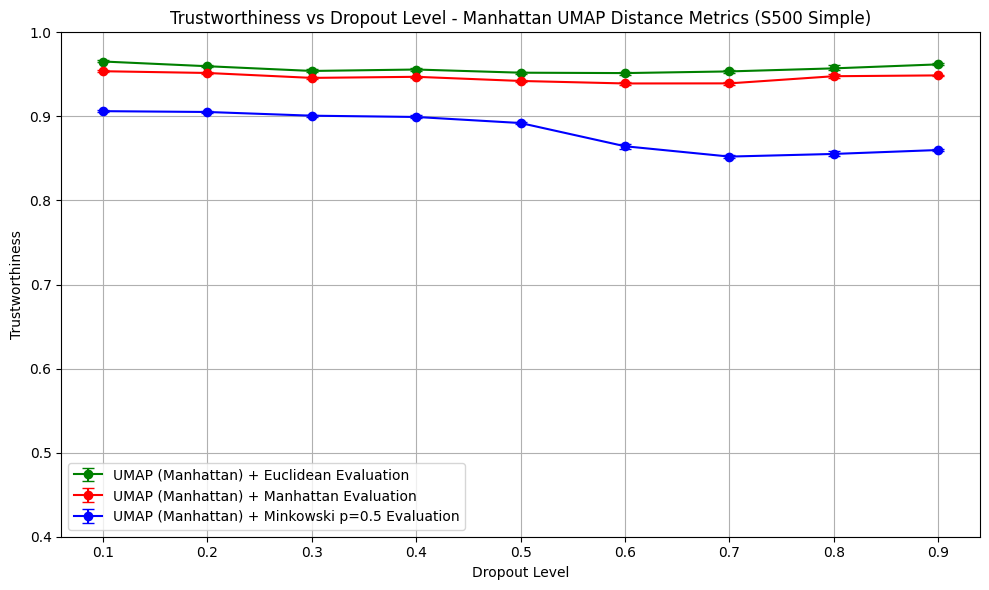

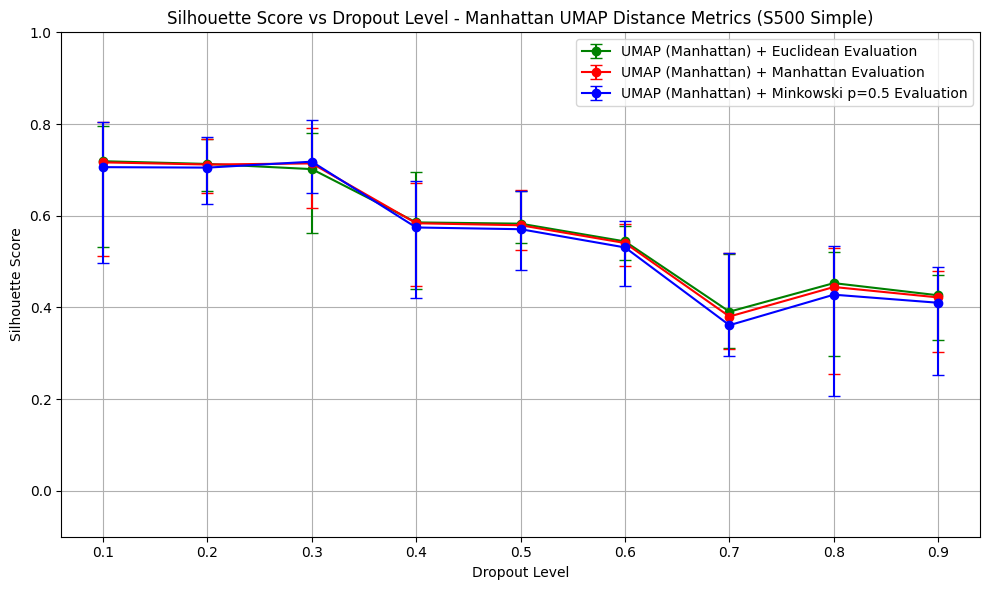

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and color mapping
eval_labels = {
    'euclidean': 'Euclidean Evaluation',
    'manhattan': 'Manhattan Evaluation',
    'minkowski_0.5': 'Minkowski p=0.5 Evaluation'
}
colors = {
    'euclidean': 'green',
    'manhattan': 'red',
    'minkowski_0.5': 'blue'
}

# Extract dropout levels
dropout_levels = [round(i / 10, 1) for i in range(1, 10)]

# --- Plot Trustworthiness ---
plt.figure(figsize=(10, 6))
for eval_metric in eval_labels:
    means = []
    mins = []
    maxs = []
    for d in dropout_levels:
        entry = all_results[f"dropout_{d}"][eval_metric]
        means.append(entry['trustworthiness_mean'])
        mins.append(entry['trustworthiness_min'])
        maxs.append(entry['trustworthiness_max'])

    err_low = np.array(means) - np.array(mins)
    err_high = np.array(maxs) - np.array(means)

    plt.errorbar(dropout_levels, means, yerr=[err_low, err_high],
                 label=f"UMAP (Manhattan) + {eval_labels[eval_metric]}",
                 fmt='-o', capsize=4, color=colors[eval_metric])

plt.title("Trustworthiness vs Dropout Level - Manhattan UMAP Distance Metrics (S500 Simple)")
plt.xlabel("Dropout Level")
plt.ylabel("Trustworthiness")
plt.ylim(0.4, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# --- Plot Silhouette Score ---
plt.figure(figsize=(10, 6))
for eval_metric in eval_labels:
    means = []
    mins = []
    maxs = []
    for d in dropout_levels:
        entry = all_results[f"dropout_{d}"][eval_metric]
        means.append(entry['silhouette_mean'])
        mins.append(entry['silhouette_min'])
        maxs.append(entry['silhouette_max'])

    err_low = np.array(means) - np.array(mins)
    err_high = np.array(maxs) - np.array(means)

    plt.errorbar(dropout_levels, means, yerr=[err_low, err_high],
                 label=f"UMAP (Manhattan) + {eval_labels[eval_metric]}",
                 fmt='-o', capsize=4, color=colors[eval_metric])

plt.title("Silhouette Score vs Dropout Level - Manhattan UMAP Distance Metrics (S500 Simple)")
plt.xlabel("Dropout Level")
plt.ylabel("Silhouette Score")
plt.ylim(-0.1, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
